# Testing of JAXGeometry

In [1]:
from jaxgeometry.manifolds import Euclidean
from jaxgeometry.setup import dts
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp

2023-10-12 22:34:08.678398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
RN = Euclidean(N=2)
jstoch.Brownian_coords(RN)
jstat.diffusion_mean(RN)

using M.Exp for Logarithm


In [3]:
RN.Gamma_g(jnp.ones(2))

Array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]], dtype=float32)

In [4]:
theta = jnp.linspace(0,2*jnp.pi, 100)

X_obs = (jnp.array([jnp.cos(theta), jnp.sin(theta)]).T, jnp.zeros(100))
x0 = (jnp.zeros(2), jnp.zeros(1))

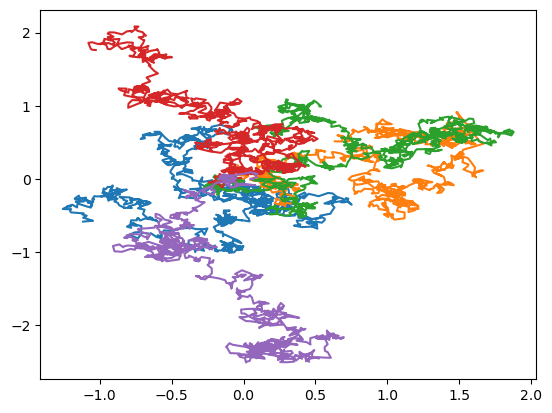

In [5]:
import numpy as np
from jaxgeometry.setup import dts, dWs
N = 5
xss = np.zeros((N,1000,RN.dim))
chartss = np.zeros((N,1000,x0[1].shape[0]))
for i in range(N):
    dt = dts(n_steps=1000)
    (ts,xs,charts) = RN.Brownian_coords(x0,dt,dWs(RN.dim, dt))
    xss[i] = xs
    chartss[i] = charts
    
# plot
import matplotlib.pyplot as plt
plt.figure()
for i in range(N):
    plt.plot(xss[i][:,0], xss[i][:,1])

In [29]:
from jaxgeometry.stochastics.GRW import initialize
from jaxgeometry.stochastics.product_sde import tile

N = 5
initialize(RN)
xss = np.zeros((N,1000,RN.dim))
chartss = np.zeros((N,1000,x0[1].shape[0]))
for i in range(N):
    dt = dts(n_steps=1000)
    (ts,xs,charts) = RN.GRW(x0,dt,dWs(RN.dim, dt))
    xss[i] = xs
    chartss[i] = charts
    
_dts = dts(n_steps=1000)
x0s = tile(x0, 10)
print(x0s[0].shape)
(ts,xss,charts) = RN.product_GRW(x0s,
              _dts, dWs(10*RN.dim,_dts).reshape(10,-1,RN.dim))
    
# plot
import matplotlib.pyplot as plt
plt.figure()
for i in range(N):
    plt.plot(xss[i][:,0], xss[i][:,1])

TypeError: <lambda>() missing 1 required positional argument: 'dW'

In [30]:
x0s = tile(x0, 2**3)

In [ ]:
jnp.repeat(x0[0], 10, axis=0).shape

In [ ]:
x0s[0].shape

In [ ]:
%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = RN.diffusion_mean(X_obs,num_steps=10, N=100)

In [ ]:
# Creating the plot.
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(X_obs[0][:,0], X_obs[0][:,1], s=10, color='black', label='Observations')
#ax.scatter(mu_true_est[0][:,0], mu_true_est[0][:,1], s=20*t_true_est, color='orange', label=r'$\nabla_{y}\ln p(x,y,t)$')
ax.scatter(mu_bridge[-1][0][0], mu_bridge[-1][0][1], color='red', label=r'Bridge Sampling',alpha=.5)
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
#ax.set_title(r'Diffusion Mean Estimates')
ax.legend(loc='lower center', fontsize=20)
ax.grid()
fig.savefig('Figures/r2_estimates.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

In [ ]:
RN.mlxt_hk(X_obs)

In [ ]:
RN.diffusion_mean_ll((jnp.zeros(2), jnp.zeros(1)), jnp.array([.5], dtype=jnp.float32), X_obs, N=100)

In [ ]:
from jax import vmap

In [ ]:
jnp.mean(vmap(lambda x: RN.log_hk((jnp.zeros(2), jnp.zeros(1)), x, jnp.ones(1)*0.5))(X_obs))

In [ ]:
thetas

In [ ]:
jstat.diffusion_mean(RN)

In [ ]:
x = (jnp.zeros(2), jnp.zeros(1))
y = (jnp.ones(2), jnp.zeros(1))
dt = dts()

v = RN.Log(x,y)
curve = RN.geodesic(x,v[0],dts())
parallel_transport = RN.parallel_transport(v[0],dts(),x[0],x[1],jnp.zeros(2))

In [ ]:
((x[0]+jnp.cumsum(dt)[:,None]*v[0]).T).shape

In [ ]:
jnp.tile(v[0], (1, len(dt))).shape

In [ ]:
len(dt)

In [ ]:
print((x[0]+jnp.cumsum(dt)[:,None]*v[0]).shape)
print(jnp.tile(v[0], (len(dt), 1)).shape)

In [ ]:
jnp.cumsum(dt)

In [ ]:
from jax import vmap
val = vmap(lambda v: RN.norm(x,v))(curve[1][:,1])

In [ ]:
jnp.diff(curve[0])

In [ ]:
(val[1:]+val[:-1])*0.5

In [7]:
RN.dist(x,y)

NameError: name 'x' is not defined

## VSM

In [166]:
file_path = 'scores/R2/vsm/'

In [167]:
from jaxgeometry.statistics.score_matching import model_loader

In [168]:
state = model_loader.load_model(file_path)

In [169]:
#jax
import jax.numpy as jnp
from jax import vmap, Array
from jax.nn import tanh

#haiku
import haiku as hk

#random
import random

In [170]:
from scores import models

if RN.dim<10:
    layers = [50,100,100,50]
elif RN.dim<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]

s1_model = hk.transform(lambda x: models.MLP_s1(dim=RN.dim, layers=layers)(x))
s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=RN.dim, r = max(N_dim//2,1))(x))

In [171]:
import jax
model = s1_model
rng_key = jax.random.PRNGKey(2712)
def grady_log_model(x,y,t):
    
    return model.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_model(x,y,t):
    
    grad_val = grady_log_model(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_model(x, y, t)))

In [206]:
model.apply(state.params,rng_key, jnp.hstack((jnp.zeros(2), jnp.zeros(2)+0.01, 0.1)))

Array([-0.10503662, -0.11159581], dtype=float32)

In [ ]:
(x-y)/t

In [226]:
from jax import lax

def ode_solver(x0,T):
    
    def step(carry,dt):
        
        xt, chart, pt, t = carry
        
        #pt += 0.5*RN.div(y, lambda y: pt*grady_log_model(x,y,t+dt))*dt
        
        #xt -= 0.5*grady_log_model(x0,(xt,chart),t)*dt
        xt -= 0.5*grady_log_model(x0, (xt+dt,chart), T)*dt
        pt = RN.div((xt,chart), lambda y: grady_log_model(x0,y,t))*dt
        
        return (xt,chart,pt,t+dt), (xt, chart,pt,t+dt)
    
    dt = dts(T=T, n_steps=100)
    
    out, _ = lax.scan(step, init=(*x0, 0.0, dt[0]), xs=dt)
    
    xt, chart, pt = out[0], out[1], out[2]
    
    return xt, chart, jnp.exp(pt)
    
    
        
    

In [227]:
ode_solver((jnp.zeros(2), jnp.zeros(1)), 1.0)

(Array([0.0093473 , 0.01404977], dtype=float32),
 Array([0.], dtype=float32),
 Array(0.9801821, dtype=float32))

In [215]:
grady_log_model((jnp.zeros(2), jnp.zeros(1)), (0.5*jnp.ones(2), jnp.zeros(1)), 0.5)

Array([-1.0054635, -1.0114901], dtype=float32)

In [228]:
key = jax.random.PRNGKey(2712)
x0 = (jax.random.normal(key,shape=(10000,2))*1/1000, jnp.zeros(10000))

In [229]:
test = vmap(lambda x,chart: ode_solver((x, chart), 1.0))(x0[0],x0[1])

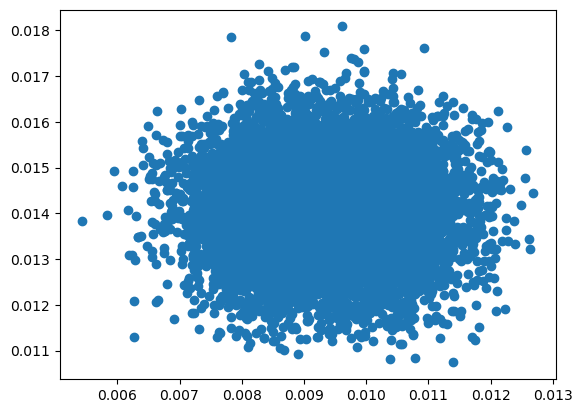

In [230]:
plt.scatter(test[0][:,0], test[0][:,1])

In [231]:
jnp.var(test[0][:,0])

Array(1.0304293e-06, dtype=float32)

In [184]:
x_test = (0.01*jnp.ones(2), jnp.zeros(1))

In [185]:
jnp.sum(jnp.linalg.norm(test[0]-x_test[0], axis=1)<0.01)/10000

Array(0.343, dtype=float32)

In [187]:
jnp.mean(test[2][jnp.linalg.norm(test[0]-x_test[0], axis=1)<0.01])

Array(0.99800026, dtype=float32)

In [188]:
RN.hk((jnp.zeros(2), jnp.zeros(1)), (0.01*jnp.ones(2), jnp.zeros(1)), 1.0)

Array(0.15913902, dtype=float32)

In [22]:
#Source: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / jnp.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return jnp.arccos(jnp.clip(jnp.dot(v1_u, v2_u), -1.0, 1.0))

In [23]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere
#Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
# Creating the theta and phi values
intervals = 1000

min_x = -2.0
max_x = 2.0
min_t = 1e-8
max_t = 1.0

x1 = jnp.linspace(min_x, max_x, intervals)
x2 = jnp.linspace(min_x, max_x, intervals)
t1 = jnp.linspace(min_t, max_t, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda y,t: RN.grady_log_hk(x0, (y, jnp.zeros(1)), t)[0]
numerical_grad = lambda y,t: grady_log_model(x0, (y, jnp.zeros(1)), t)
heat_map = vmap(lambda x2,t: vmap(lambda x1: angle_between(theoretical_grad(x1,t),
                                                         numerical_grad(x1,t)))(x2))(X_heat,t1)

# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[min_x,max_x,min_x,max_x])
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_title(r'$\cos^{-1}\frac{\langle s_{\theta}(x,y,t), \nabla_{y}\ln p(x,y,t) \rangle_{\mathbb{R}^{2}}}{||s_{\theta}(x,y,t)||_{\mathbb{R}^{2}}\cdot||\nabla_{y}\ln p(x,y,t)||_{\mathbb{R}^{2}}}$',
            fontsize=20)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax2.set_xticks(t1[-1::-100])
ax2.set_xlabel(r'$t$')
ax3 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax3.set_yticks(t1[-1::-100])
ax3.set_ylabel(r'$t$')
cax = plt.axes([1.0, 0.075, 0.05, 0.825])
fig.colorbar(m, ax=ax, cax=cax)
ax.autoscale(False)
ax2.autoscale(False)
ax3.autoscale(False)
fig.savefig('Figures/r2_angle.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

ValueError: Unable to retrieve parameter 'w' for module 'rn_s1/linear' All parameters must be created as part of `init`.

### Plotting the Norm Difference in $x$

In [ ]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

# Creating the theta and phi values
intervals = 1000

min_x = -2.0
max_x = 2.0
min_t = 1e-8
max_t = 1.0

x1 = jnp.linspace(min_x, max_x, intervals)
x2 = jnp.linspace(min_x, max_x, intervals)
t1 = jnp.linspace(min_t, max_t, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda y,t: RN.grady_log_hk(x0, (y, jnp.zeros(1)), t)[0]
numerical_grad = lambda y,t: grady_log_model(x0, (y, jnp.zeros(1)), t)
heat_map = vmap(lambda x2,t: vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1,t)-numerical_grad(x1,t))**2)(x2))(X_heat,t1)

# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[min_x,max_x,min_x,max_x])
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_title(r'$||s_{\theta}(x,y,t)-\nabla_{y}\ln p(x,y,t)||_{\mathbb{R}^{2}}^{2}$', fontsize=20)
ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax2.set_xticks(t1[-1::-100])
ax2.set_xlabel(r'$t$')
ax3 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax3.set_yticks(t1[-1::-100])
ax3.set_ylabel(r'$t$')
ax.set_ylim((min_x,max_x))
ax.set_xlim((min_x,max_x))
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
cax = plt.axes([1.0, 0.075, 0.05, 0.825])
fig.colorbar(m, ax=ax, cax=cax)
ax.autoscale(False)
ax2.autoscale(False)
ax3.autoscale(False)
fig.savefig('Figures/r2_norm.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

In [24]:
from jaxgeometry.statistics.score_matching import diffusion_mean
from jaxgeometry.setup import *

In [25]:
def s1_grad(x,y,t):
    
    return model.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def s2_grad(x,y,t):
    
    ggrad = jacfwdx(lambda y: model.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

diffusion_mean.initialize(RN, s1_model=s1_grad, s2_model = s2_grad)

In [26]:
theta = jnp.linspace(0,2*jnp.pi, 100)

X_obs = (jnp.array([jnp.cos(theta), jnp.sin(theta)]).T, jnp.zeros(100))
x0 = (jnp.zeros(2), jnp.zeros(1))

In [27]:
mu, T, _, _ = RN.sm_dmxt(X_obs, (jnp.ones(2), jnp.zeros(1)), jnp.array([1.0]))

ValueError: Unable to retrieve parameter 'w' for module 'rn_s1/linear' All parameters must be created as part of `init`.

NameError: name 'mu' is not defined

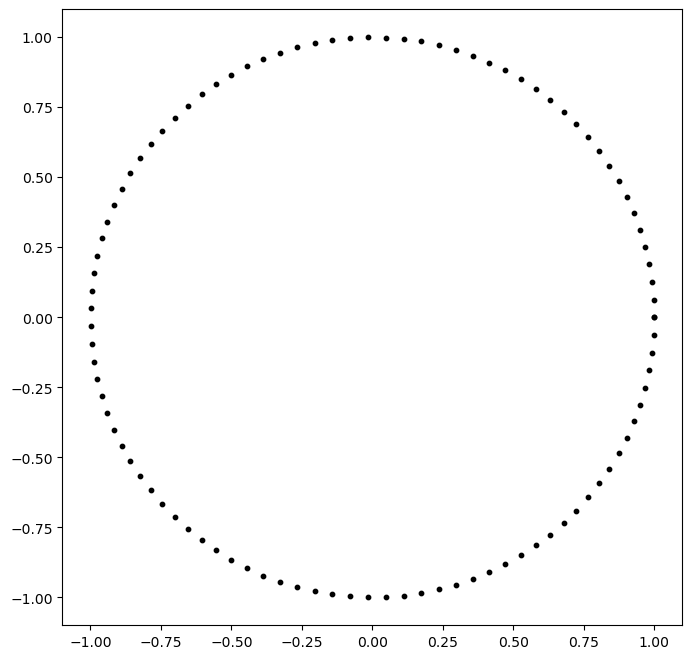

In [28]:
# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(X_obs[0][:,0], X_obs[0][:,1], s=10, color='black', label='Observations')
#ax.scatter(mu_true_est[0][:,0], mu_true_est[0][:,1], s=20*t_true_est, color='orange', label=r'$\nabla_{y}\ln p(x,y,t)$')
ax.scatter(mu[0][-1,0], mu[0][-1,1])
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
#ax.set_title(r'Diffusion Mean Estimates')
ax.legend(loc='lower center', fontsize=20)
ax.grid()
fig.savefig('Figures/r2_estimates.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

In [29]:
print(mu)

NameError: name 'mu' is not defined

In [30]:
print(T)

1.0


## DSM

In [82]:
file_path = 'scores/R2/dsm/'

In [83]:
from jaxgeometry.statistics.score_matching import model_loader

In [84]:
state = model_loader.load_model(file_path)

In [85]:
#jax
import jax.numpy as jnp
from jax import vmap, Array
from jax.nn import tanh

#haiku
import haiku as hk

#random
import random

In [86]:
from scores import models

if RN.dim<10:
    layers = [50,100,100,50]
elif RN.dim<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]

s1_model = hk.transform(lambda x: models.MLP_s1(dim=RN.dim, layers=layers)(x))
s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=RN.dim, r = max(N_dim//2,1))(x))

In [87]:
import jax
model = s1_model
rng_key = jax.random.PRNGKey(2712)
def grady_log_model(x,y,t):
    
    return model.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_model(x,y,t):
    
    grad_val = grady_log_model(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_model(x, y, t)))

In [88]:
#Source: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / jnp.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return jnp.arccos(jnp.clip(jnp.dot(v1_u, v2_u), -1.0, 1.0))

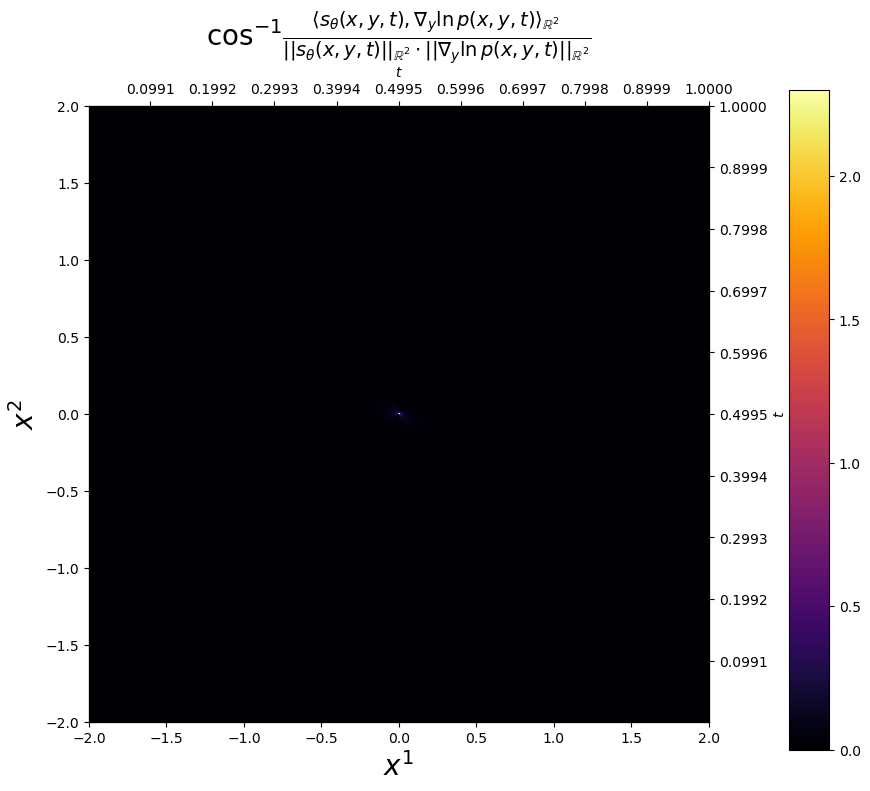

In [89]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere
#Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
# Creating the theta and phi values
intervals = 1000

min_x = -2.0
max_x = 2.0
min_t = 1e-8
max_t = 1.0

x1 = jnp.linspace(min_x, max_x, intervals)
x2 = jnp.linspace(min_x, max_x, intervals)
t1 = jnp.linspace(min_t, max_t, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda y,t: RN.grady_log_hk(x0, (y, jnp.zeros(1)), t)[0]
numerical_grad = lambda y,t: grady_log_model(x0, (y, jnp.zeros(1)), t)
heat_map = vmap(lambda x2,t: vmap(lambda x1: angle_between(theoretical_grad(x1,t),
                                                         numerical_grad(x1,t)))(x2))(X_heat,t1)

# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[min_x,max_x,min_x,max_x])
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_title(r'$\cos^{-1}\frac{\langle s_{\theta}(x,y,t), \nabla_{y}\ln p(x,y,t) \rangle_{\mathbb{R}^{2}}}{||s_{\theta}(x,y,t)||_{\mathbb{R}^{2}}\cdot||\nabla_{y}\ln p(x,y,t)||_{\mathbb{R}^{2}}}$',
            fontsize=20)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax2.set_xticks(t1[-1::-100])
ax2.set_xlabel(r'$t$')
ax3 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax3.set_yticks(t1[-1::-100])
ax3.set_ylabel(r'$t$')
cax = plt.axes([1.0, 0.075, 0.05, 0.825])
fig.colorbar(m, ax=ax, cax=cax)
ax.autoscale(False)
ax2.autoscale(False)
ax3.autoscale(False)
fig.savefig('Figures/r2_angle.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

### Plotting the Norm Difference in $x$

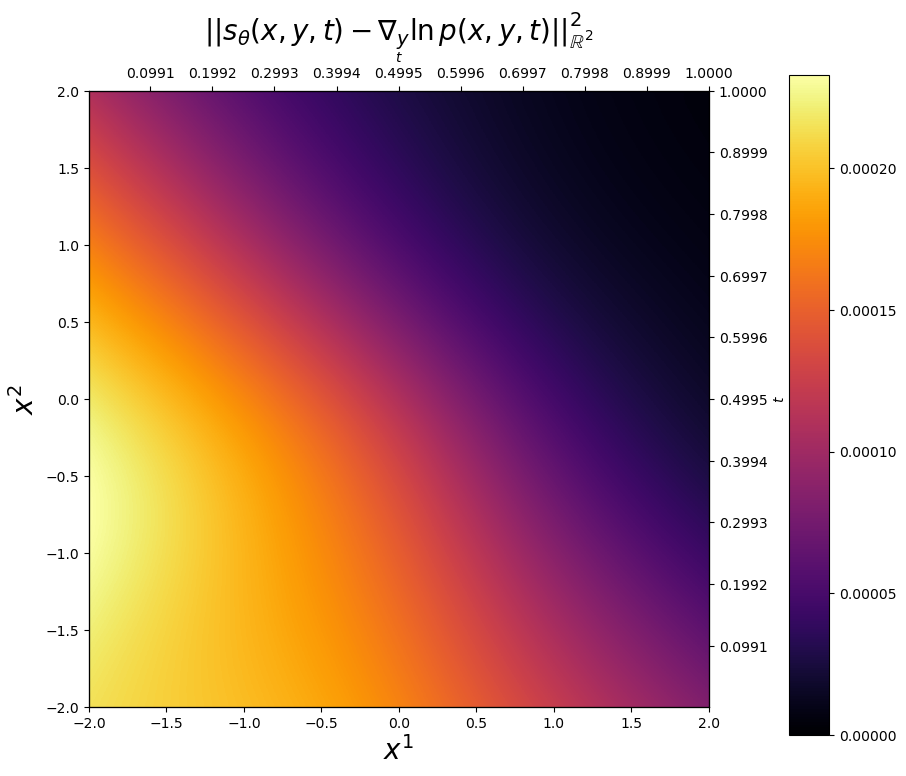

In [90]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

# Creating the theta and phi values
intervals = 1000

min_x = -2.0
max_x = 2.0
min_t = 1e-8
max_t = 1.0

x1 = jnp.linspace(min_x, max_x, intervals)
x2 = jnp.linspace(min_x, max_x, intervals)
t1 = jnp.linspace(min_t, max_t, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda y,t: RN.grady_log_hk(x0, (y, jnp.zeros(1)), t)[0]
numerical_grad = lambda y,t: grady_log_model(x0, (y, jnp.zeros(1)), t)
heat_map = vmap(lambda x2,t: vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1,t)-numerical_grad(x1,t))**2)(x2))(X_heat,t1)

# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[min_x,max_x,min_x,max_x])
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_title(r'$||s_{\theta}(x,y,t)-\nabla_{y}\ln p(x,y,t)||_{\mathbb{R}^{2}}^{2}$', fontsize=20)
ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax2.set_xticks(t1[-1::-100])
ax2.set_xlabel(r'$t$')
ax3 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax3.set_yticks(t1[-1::-100])
ax3.set_ylabel(r'$t$')
ax.set_ylim((min_x,max_x))
ax.set_xlim((min_x,max_x))
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
cax = plt.axes([1.0, 0.075, 0.05, 0.825])
fig.colorbar(m, ax=ax, cax=cax)
ax.autoscale(False)
ax2.autoscale(False)
ax3.autoscale(False)
fig.savefig('Figures/r2_norm.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

In [91]:
from jaxgeometry.statistics.score_matching import diffusion_mean
from jaxgeometry.setup import *

In [92]:
def s1_grad(x,y,t):
    
    return model.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def s2_grad(x,y,t):
    
    ggrad = jacfwdx(lambda y: model.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

diffusion_mean.initialize(RN, s1_model=s1_grad, s2_model = s2_grad)

In [93]:
theta = jnp.linspace(0,2*jnp.pi, 100)

X_obs = (jnp.array([jnp.cos(theta), jnp.sin(theta)]).T, jnp.zeros(100))
x0 = (jnp.zeros(2), jnp.zeros(1))

In [94]:
mu, T, _, _ = RN.sm_dmxt(X_obs, (jnp.ones(2), jnp.zeros(1)), jnp.array([0.1]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


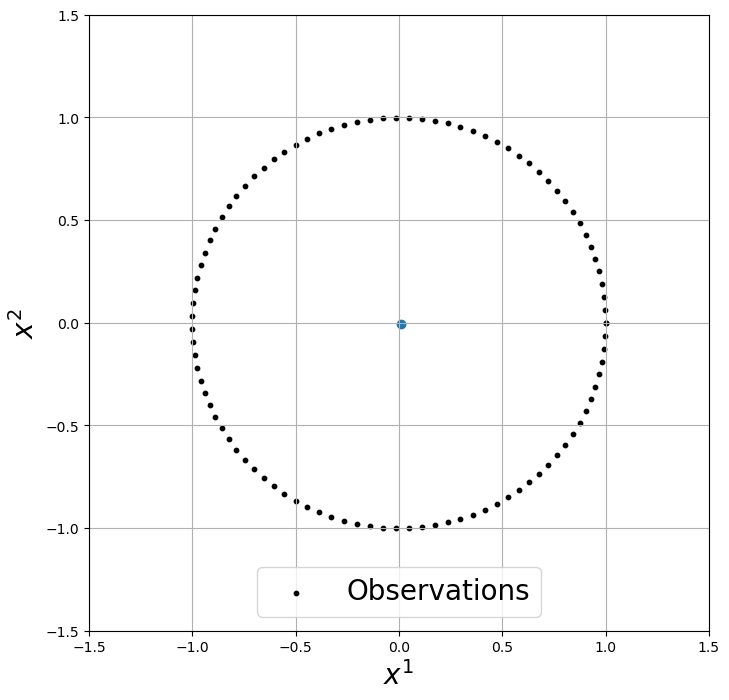

In [95]:
# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(X_obs[0][:,0], X_obs[0][:,1], s=10, color='black', label='Observations')
#ax.scatter(mu_true_est[0][:,0], mu_true_est[0][:,1], s=20*t_true_est, color='orange', label=r'$\nabla_{y}\ln p(x,y,t)$')
ax.scatter(mu[0][-1,0], mu[0][-1,1])
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
#ax.set_title(r'Diffusion Mean Estimates')
ax.legend(loc='lower center', fontsize=20)
ax.grid()
fig.savefig('Figures/r2_estimates.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

In [96]:
print(mu)

(Array([[ 0.9000007 ,  0.9000007 ],
       [ 0.8083762 ,  0.808338  ],
       [ 0.72364897,  0.7235304 ],
       ...,
       [ 0.01179098, -0.00477877],
       [ 0.01179098, -0.00477877],
       [ 0.01179097, -0.00477877]], dtype=float32), Array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
      

In [97]:
print(T)

[[0.19999935]
 [0.2801925 ]
 [0.3469563 ]
 [0.4038802 ]
 [0.45317426]
 [0.49631554]
 [0.5343549 ]
 [0.56807745]
 [0.59809095]
 [0.62488043]
 [0.6488417 ]
 [0.6703039 ]
 [0.6895453 ]
 [0.70680386]
 [0.72228545]
 [0.7361696 ]
 [0.748614  ]
 [0.7597581 ]
 [0.76972574]
 [0.77862734]
 [0.7865617 ]
 [0.79361767]
 [0.7998749 ]
 [0.8054052 ]
 [0.8102734 ]
 [0.814538  ]
 [0.81825185]
 [0.8214627 ]
 [0.8242137 ]
 [0.826544  ]
 [0.8284888 ]
 [0.8300803 ]
 [0.8313472 ]
 [0.83231586]
 [0.8330099 ]
 [0.8334508 ]
 [0.83365804]
 [0.8336493 ]
 [0.83344054]
 [0.8330464 ]
 [0.8324801 ]
 [0.83175373]
 [0.8308784 ]
 [0.8298641 ]
 [0.82872015]
 [0.82745504]
 [0.8260767 ]
 [0.8245923 ]
 [0.8230086 ]
 [0.8213318 ]
 [0.81956774]
 [0.81772184]
 [0.8157991 ]
 [0.81380427]
 [0.81174177]
 [0.80961573]
 [0.80743   ]
 [0.80518836]
 [0.8028941 ]
 [0.8005505 ]
 [0.7981606 ]
 [0.7957272 ]
 [0.7932529 ]
 [0.7907402 ]
 [0.78819144]
 [0.78560877]
 [0.7829942 ]
 [0.7803497 ]
 [0.7776769 ]
 [0.7749775 ]
 [0.77225304]
 [0.76

## S2

In [6]:
file_path_s1 = 'scores/R2/dsm/'
file_path_s2 = 'scores/R2/s2/'

In [7]:
from jaxgeometry.statistics.score_matching import model_loader

In [8]:
import jax.random as jran
state_s1 = model_loader.load_model(file_path_s1)
state_s2 = model_loader.load_model(file_path_s2)
rng_key = jran.PRNGKey(2712)

In [9]:
#jax
import jax.numpy as jnp
from jax import vmap, Array
from jax.nn import tanh

#haiku
import haiku as hk

#random
import random

In [10]:
from scores import models

if RN.dim<10:
    layers = [50,100,100,50]
elif RN.dim<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]

s1_model = hk.transform(lambda x: models.MLP_s1(dim=RN.dim, layers=layers)(x))
s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=RN.dim, r = max(RN.dim//2,1))(x))

In [11]:
def ggrady_log_model(x,y,t):
        
    return s2_model.apply(state_s2.params,rng_key, jnp.hstack((x[0], y[0], t)))

def grady_log_model(x,y,t):
    
    return s1_model.apply(state_s1.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_model(x,y,t):
    
    s1 = grady_log_model(x, y, t)
    s2 = s2_model.apply(state_s2.params, rng_key, jnp.hstack((x[0], y[0], t)))    
    div = jnp.trace(s2)+.5*jnp.dot(s1,jacfwdx(RN.logAbsDet)(x))
                                   
    return 0.5*(jnp.dot(s1, s1)+div)

In [12]:
#Source: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / jnp.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return jnp.arccos(jnp.clip(jnp.dot(v1_u, v2_u), -1.0, 1.0))

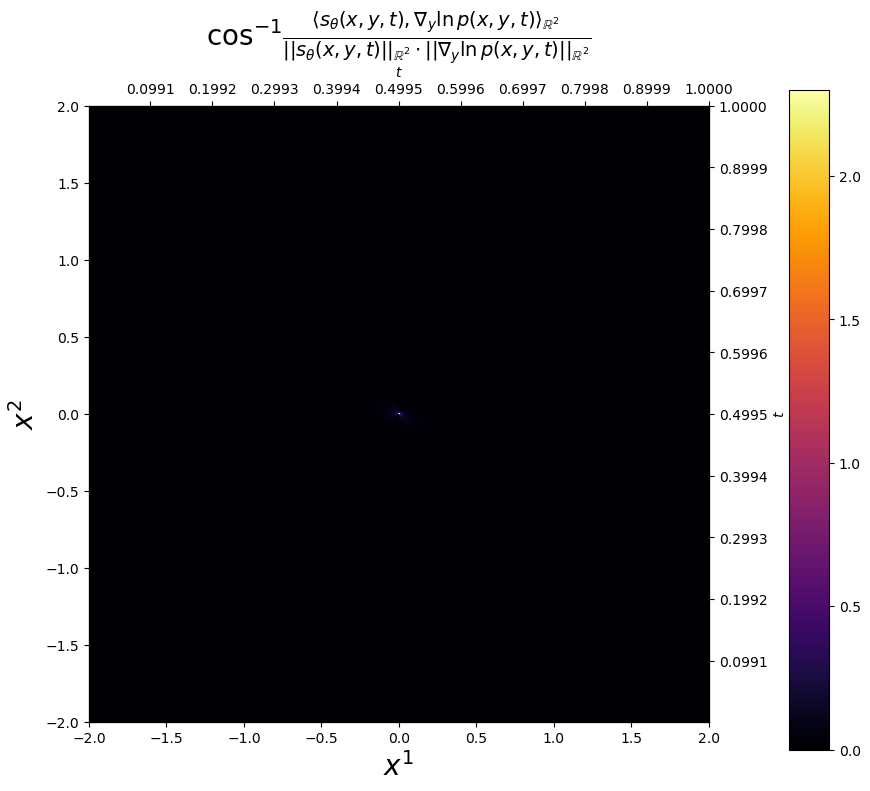

In [13]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere
#Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
# Creating the theta and phi values
intervals = 1000

min_x = -2.0
max_x = 2.0
min_t = 1e-8
max_t = 1.0

x1 = jnp.linspace(min_x, max_x, intervals)
x2 = jnp.linspace(min_x, max_x, intervals)
t1 = jnp.linspace(min_t, max_t, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda y,t: RN.grady_log_hk(x0, (y, jnp.zeros(1)), t)[0]
numerical_grad = lambda y,t: grady_log_model(x0, (y, jnp.zeros(1)), t)
heat_map = vmap(lambda x2,t: vmap(lambda x1: angle_between(theoretical_grad(x1,t),
                                                         numerical_grad(x1,t)))(x2))(X_heat,t1)

# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[min_x,max_x,min_x,max_x])
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_title(r'$\cos^{-1}\frac{\langle s_{\theta}(x,y,t), \nabla_{y}\ln p(x,y,t) \rangle_{\mathbb{R}^{2}}}{||s_{\theta}(x,y,t)||_{\mathbb{R}^{2}}\cdot||\nabla_{y}\ln p(x,y,t)||_{\mathbb{R}^{2}}}$',
            fontsize=20)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax2.set_xticks(t1[-1::-100])
ax2.set_xlabel(r'$t$')
ax3 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax3.set_yticks(t1[-1::-100])
ax3.set_ylabel(r'$t$')
cax = plt.axes([1.0, 0.075, 0.05, 0.825])
fig.colorbar(m, ax=ax, cax=cax)
ax.autoscale(False)
ax2.autoscale(False)
ax3.autoscale(False)
fig.savefig('Figures/r2_angle.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

### Plotting the Norm Difference in $x$

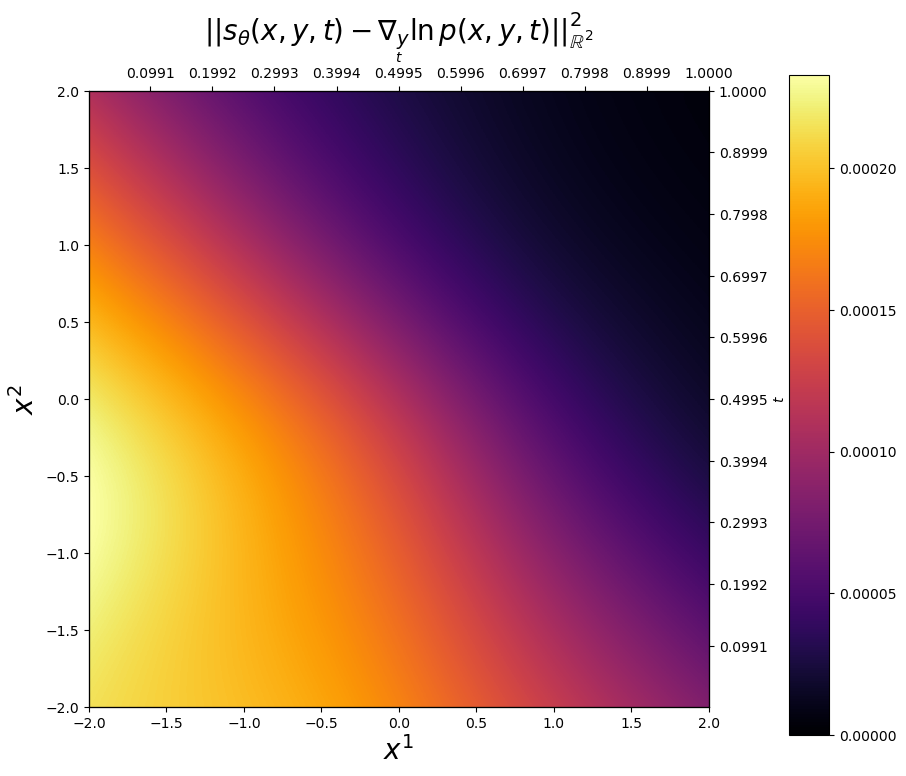

In [14]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

# Creating the theta and phi values
intervals = 1000

min_x = -2.0
max_x = 2.0
min_t = 1e-8
max_t = 1.0

x1 = jnp.linspace(min_x, max_x, intervals)
x2 = jnp.linspace(min_x, max_x, intervals)
t1 = jnp.linspace(min_t, max_t, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda y,t: RN.grady_log_hk(x0, (y, jnp.zeros(1)), t)[0]
numerical_grad = lambda y,t: grady_log_model(x0, (y, jnp.zeros(1)), t)
heat_map = vmap(lambda x2,t: vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1,t)-numerical_grad(x1,t))**2)(x2))(X_heat,t1)

# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[min_x,max_x,min_x,max_x])
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_title(r'$||s_{\theta}(x,y,t)-\nabla_{y}\ln p(x,y,t)||_{\mathbb{R}^{2}}^{2}$', fontsize=20)
ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax2.set_xticks(t1[-1::-100])
ax2.set_xlabel(r'$t$')
ax3 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax3.set_yticks(t1[-1::-100])
ax3.set_ylabel(r'$t$')
ax.set_ylim((min_x,max_x))
ax.set_xlim((min_x,max_x))
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
cax = plt.axes([1.0, 0.075, 0.05, 0.825])
fig.colorbar(m, ax=ax, cax=cax)
ax.autoscale(False)
ax2.autoscale(False)
ax3.autoscale(False)
fig.savefig('Figures/r2_norm.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

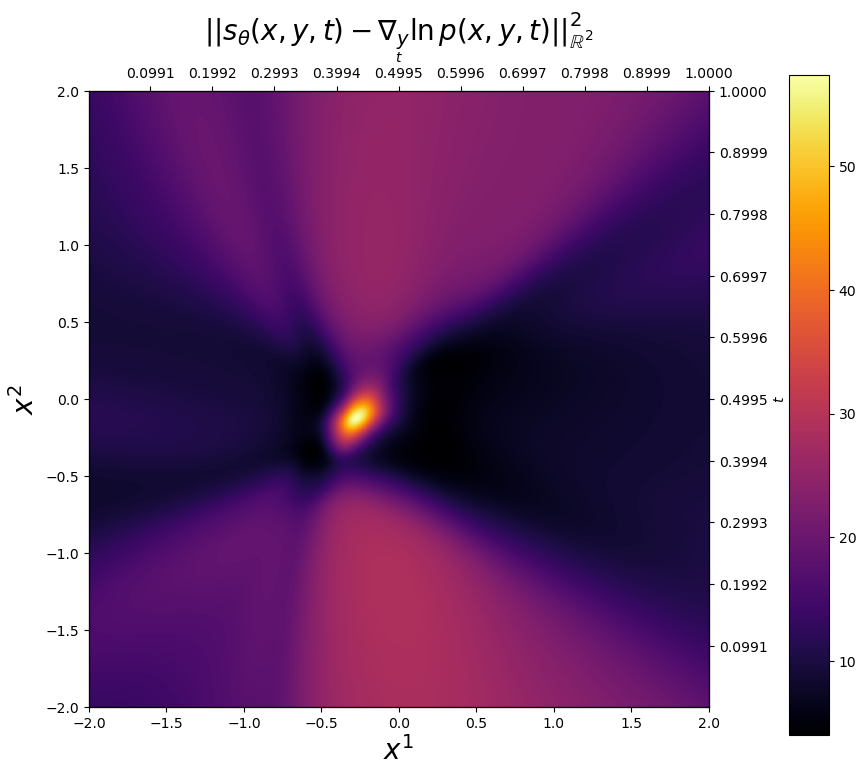

In [15]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

# Creating the theta and phi values
intervals = 1000

min_x = -2.0
max_x = 2.0
min_t = 1e-8
max_t = 1.0

x1 = jnp.linspace(min_x, max_x, intervals)
x2 = jnp.linspace(min_x, max_x, intervals)
t1 = jnp.linspace(min_t, max_t, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda y,t: RN.ggrady_log_hk(x0, (y, jnp.zeros(1)), 0.5)[0]
numerical_grad = lambda y,t: ggrady_log_model(x0, (y, jnp.zeros(1)), 0.5)
heat_map = vmap(lambda x2,t: vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1,t)-numerical_grad(x1,t))**2)(x2))(X_heat,t1)

# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[min_x,max_x,min_x,max_x])
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_title(r'$||s_{\theta}(x,y,t)-\nabla_{y}\ln p(x,y,t)||_{\mathbb{R}^{2}}^{2}$', fontsize=20)
ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax2.set_xticks(t1[-1::-100])
ax2.set_xlabel(r'$t$')
ax3 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax3.set_yticks(t1[-1::-100])
ax3.set_ylabel(r'$t$')
ax.set_ylim((min_x,max_x))
ax.set_xlim((min_x,max_x))
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
cax = plt.axes([1.0, 0.075, 0.05, 0.825])
fig.colorbar(m, ax=ax, cax=cax)
ax.autoscale(False)
ax2.autoscale(False)
ax3.autoscale(False)
fig.savefig('Figures/r2_norm.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

In [16]:
print(jnp.min(heat_map))
print(jnp.max(heat_map))

4.000058
57.41577


In [17]:
from jaxgeometry.statistics.score_matching import diffusion_mean
from jaxgeometry.setup import *

In [18]:
def s1_grad(x,y,t):
    
    return s1_model.apply(state_s1.params,rng_key, jnp.hstack((x[0], y[0], t)))

def s2_grad(x,y,t):
    
    return s2_model.apply(state_s2.params,rng_key, jnp.hstack((x[0], y[0], t))).squeeze()

diffusion_mean.initialize(RN, s1_model=s1_grad, s2_model = s2_grad)

In [19]:
diffusion_mean.initialize(RN, s1_model=s1_grad, s2_model=s2_grad)

In [20]:
theta = jnp.linspace(0,2*jnp.pi, 100)

X_obs = (jnp.array([jnp.cos(theta), jnp.sin(theta)]).T, jnp.zeros(100))
x0 = (jnp.zeros(2), jnp.zeros(1))

In [21]:
mu, T, _, _ = RN.sm_dmxt(X_obs, (jnp.ones(2), jnp.zeros(1)), jnp.array([0.5]))

In [22]:
T

Array([[0.5999993 ],
       [0.6920168 ],
       [0.7740168 ],
       [0.8456801 ],
       [0.9077245 ],
       [0.96128994],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


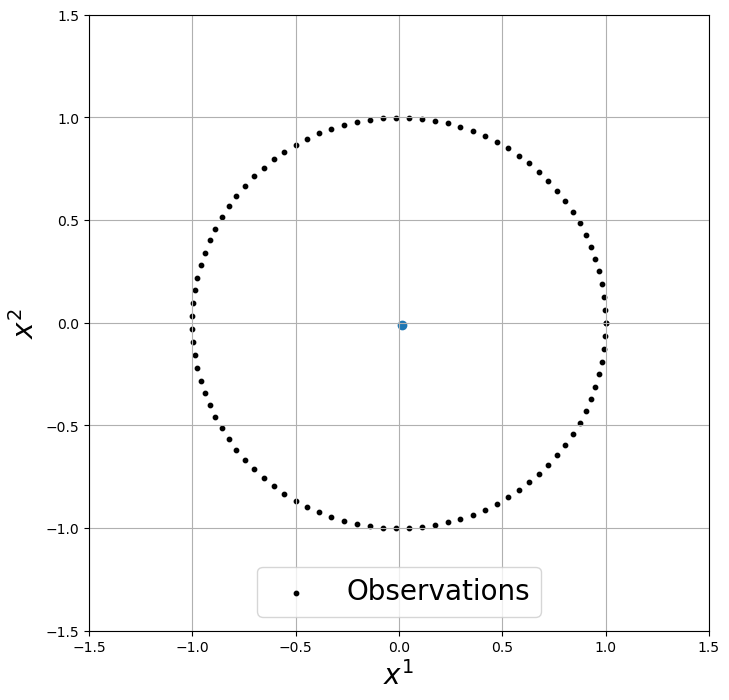

In [24]:
# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(X_obs[0][:,0], X_obs[0][:,1], s=10, color='black', label='Observations')
#ax.scatter(mu_true_est[0][:,0], mu_true_est[0][:,1], s=20*t_true_est, color='orange', label=r'$\nabla_{y}\ln p(x,y,t)$')
ax.scatter(mu[0][-1,0], mu[0][-1,1])
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
#ax.set_title(r'Diffusion Mean Estimates')
ax.legend(loc='lower center', fontsize=20)
ax.grid()
fig.savefig('Figures/r2_estimates.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

In [25]:
print(mu)

(Array([[ 0.9000007 ,  0.9000007 ],
       [ 0.8017601 ,  0.80173033],
       [ 0.7060691 ,  0.7059586 ],
       ...,
       [ 0.01374139, -0.00997551],
       [ 0.01374139, -0.00997551],
       [ 0.01374139, -0.00997551]], dtype=float32), Array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
      

In [26]:
print(T)

[[0.5999993 ]
 [0.69528615]
 [0.7842209 ]
 [0.8660827 ]
 [0.9407414 ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.  

# Old version

In [11]:
#Modules

#JAX
import jax.numpy as jnp
import jax.random as jran
from jax import lax
from jax.nn import tanh

#Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

#Scipy
import scipy.io

#haiku
import haiku as hk

#JAXGeometry
from src.plotting import *
from IPython.display import clear_output
from src.Riemannian import metric, geodesic
from src.stochastics import Brownian_coords
from src.statistics import diffusion_mean
from src.Riemannian import Log
from src.stochastics import product_sde
from src.stochastics.product_sde import tile
from src.stochastics import diagonal_conditioning

In [12]:
theta = jnp.linspace(0,2*jnp.pi, 100)

X_obs = (jnp.array([jnp.cos(theta), jnp.sin(theta)]).T, jnp.zeros(100))
x0 = (jnp.zeros(2), jnp.zeros(1))

In [21]:
#Defining manifold
N = 2
M = Euclidean(N=N)
print(M)

M.F = lambda x: x[0]

metric.initialize(M)
geodesic.initialize(M)
Brownian_coords.initialize(M)
Log.initialize(M)

M.StdLog = lambda x,y: x[0]-y[0]

using M.Exp for Logarithm
Euclidean manifold of dimension 2
using M.Exp for Logarithm


In [22]:
(product,sde_product,chart_update_product) = product_sde.initialize(M,M.sde_Brownian_coords,M.chart_update_Brownian_coords)

diffusion_mean.initialize(M)
diagonal_conditioning.initialize(M,sde_product,chart_update_product)

In [27]:
theta = jnp.linspace(0,2*jnp.pi, 100)

X_obs = (jnp.array([jnp.cos(theta), jnp.sin(theta)]).T, jnp.zeros(100))
x0 = (jnp.zeros(2), jnp.zeros(1))

%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,N=1000,num_steps=1000)

Step 0 | T: 1.130469e+01 | T: ((Array([-0.04554458, -0.0075572 ], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.020404e+01 | T: ((Array([-0.03569678,  0.00196818], dtype=float32), Array(0.21992855, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 9.269822e+00 | T: ((Array([-0.02611687,  0.01048186], dtype=float32), Array(0.22974625, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 8.474195e+00 | T: ((Array([-0.01692625,  0.01738999], dtype=float32), Array(0.2394194, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.793792e+00 | T: ((Array([-0.0082456 ,  0.02230062], dtype=float32), Array(0.24891998, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 7.209190e+00 | T: ((Array([-0.00018695,  0.02518753], dtype=float32), Array(0.25822508, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 6.704501e+00 | T: ((Array([0.00715443, 0.02630293], dtype=float32), Array(0.2673165, dtype=float32)), Array([0.], dtype

Step 58 | T: 2.517520e+00 | T: ((Array([0.0081712 , 0.00852277], dtype=float32), Array(0.49113688, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 2.508973e+00 | T: ((Array([0.00863423, 0.0087316 ], dtype=float32), Array(0.49300396, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 2.500734e+00 | T: ((Array([0.00907174, 0.00896296], dtype=float32), Array(0.49483883, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 2.492783e+00 | T: ((Array([0.00948051, 0.00920715], dtype=float32), Array(0.49664292, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 2.485106e+00 | T: ((Array([0.00985798, 0.0094549 ], dtype=float32), Array(0.49841753, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 2.477688e+00 | T: ((Array([0.01020224, 0.00969769], dtype=float32), Array(0.5001639, dtype=float32)), Array([0.], dtype=float32))
Step 64 | T: 2.470515e+00 | T: ((Array([0.01051195, 0.00992795], dtype=float32), Array(0.5018832, dtype=float32)), Array([0.], dtype=floa

Step 116 | T: 2.271946e+00 | T: ((Array([0.00986977, 0.00999904], dtype=float32), Array(0.5688308, dtype=float32)), Array([0.], dtype=float32))
Step 117 | T: 2.269944e+00 | T: ((Array([0.00989606, 0.00998334], dtype=float32), Array(0.5698329, dtype=float32)), Array([0.], dtype=float32))
Step 118 | T: 2.267981e+00 | T: ((Array([0.00992121, 0.00996973], dtype=float32), Array(0.57082725, dtype=float32)), Array([0.], dtype=float32))
Step 119 | T: 2.266055e+00 | T: ((Array([0.00994501, 0.00995849], dtype=float32), Array(0.57181376, dtype=float32)), Array([0.], dtype=float32))
Step 120 | T: 2.264167e+00 | T: ((Array([0.00996727, 0.00994978], dtype=float32), Array(0.57279265, dtype=float32)), Array([0.], dtype=float32))
Step 121 | T: 2.262314e+00 | T: ((Array([0.00998782, 0.00994367], dtype=float32), Array(0.57376397, dtype=float32)), Array([0.], dtype=float32))
Step 122 | T: 2.260497e+00 | T: ((Array([0.01000657, 0.00994012], dtype=float32), Array(0.5747278, dtype=float32)), Array([0.], dtyp

Step 173 | T: 2.200657e+00 | T: ((Array([0.00999227, 0.01000472], dtype=float32), Array(0.61555094, dtype=float32)), Array([0.], dtype=float32))
Step 174 | T: 2.199933e+00 | T: ((Array([0.00999373, 0.01000465], dtype=float32), Array(0.616213, dtype=float32)), Array([0.], dtype=float32))
Step 175 | T: 2.199221e+00 | T: ((Array([0.00999513, 0.01000441], dtype=float32), Array(0.6168706, dtype=float32)), Array([0.], dtype=float32))
Step 176 | T: 2.198521e+00 | T: ((Array([0.00999646, 0.01000404], dtype=float32), Array(0.61752367, dtype=float32)), Array([0.], dtype=float32))
Step 177 | T: 2.197832e+00 | T: ((Array([0.00999772, 0.01000355], dtype=float32), Array(0.6181723, dtype=float32)), Array([0.], dtype=float32))
Step 178 | T: 2.197155e+00 | T: ((Array([0.00999888, 0.01000298], dtype=float32), Array(0.61881644, dtype=float32)), Array([0.], dtype=float32))
Step 179 | T: 2.196489e+00 | T: ((Array([0.00999995, 0.01000236], dtype=float32), Array(0.61945623, dtype=float32)), Array([0.], dtype

Step 230 | T: 2.173499e+00 | T: ((Array([0.00999967, 0.00999995], dtype=float32), Array(0.64698184, dtype=float32)), Array([0.], dtype=float32))
Step 231 | T: 2.173208e+00 | T: ((Array([0.00999975, 0.01      ], dtype=float32), Array(0.6474337, dtype=float32)), Array([0.], dtype=float32))
Step 232 | T: 2.172921e+00 | T: ((Array([0.00999983, 0.01000005], dtype=float32), Array(0.6478826, dtype=float32)), Array([0.], dtype=float32))
Step 233 | T: 2.172639e+00 | T: ((Array([0.0099999 , 0.01000009], dtype=float32), Array(0.6483285, dtype=float32)), Array([0.], dtype=float32))
Step 234 | T: 2.172361e+00 | T: ((Array([0.00999997, 0.01000012], dtype=float32), Array(0.64877146, dtype=float32)), Array([0.], dtype=float32))
Step 235 | T: 2.172087e+00 | T: ((Array([0.01000003, 0.01000014], dtype=float32), Array(0.6492116, dtype=float32)), Array([0.], dtype=float32))
Step 236 | T: 2.171818e+00 | T: ((Array([0.01000008, 0.01000016], dtype=float32), Array(0.6496488, dtype=float32)), Array([0.], dtype=

Step 287 | T: 2.162354e+00 | T: ((Array([0.01000001, 0.01000001], dtype=float32), Array(0.6685253, dtype=float32)), Array([0.], dtype=float32))
Step 288 | T: 2.162232e+00 | T: ((Array([0.01000001, 0.01000001], dtype=float32), Array(0.66883564, dtype=float32)), Array([0.], dtype=float32))
Step 289 | T: 2.162112e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.6691439, dtype=float32)), Array([0.], dtype=float32))
Step 290 | T: 2.161994e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.66945016, dtype=float32)), Array([0.], dtype=float32))
Step 291 | T: 2.161878e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.6697544, dtype=float32)), Array([0.], dtype=float32))
Step 292 | T: 2.161763e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.67005664, dtype=float32)), Array([0.], dtype=float32))
Step 293 | T: 2.161650e+00 | T: ((Array([0.01000003, 0.01000002], dtype=float32), Array(0.67035687, dtype=float32)), Array([0.], dtyp

Step 344 | T: 2.157679e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.6832865, dtype=float32)), Array([0.], dtype=float32))
Step 345 | T: 2.157628e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.6834981, dtype=float32)), Array([0.], dtype=float32))
Step 346 | T: 2.157578e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.6837082, dtype=float32)), Array([0.], dtype=float32))
Step 347 | T: 2.157528e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.68391687, dtype=float32)), Array([0.], dtype=float32))
Step 348 | T: 2.157480e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.6841241, dtype=float32)), Array([0.], dtype=float32))
Step 349 | T: 2.157432e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.6843299, dtype=float32)), Array([0.], dtype=float32))
Step 350 | T: 2.157385e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.6845344, dtype=float32)), Array([0.], dtype=f

Step 401 | T: 2.155736e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.6932795, dtype=float32)), Array([0.], dtype=float32))
Step 402 | T: 2.155715e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.69342136, dtype=float32)), Array([0.], dtype=float32))
Step 403 | T: 2.155694e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.69356227, dtype=float32)), Array([0.], dtype=float32))
Step 404 | T: 2.155674e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.69370216, dtype=float32)), Array([0.], dtype=float32))
Step 405 | T: 2.155654e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.69384104, dtype=float32)), Array([0.], dtype=float32))
Step 406 | T: 2.155635e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.6939789, dtype=float32)), Array([0.], dtype=float32))
Step 407 | T: 2.155616e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.6941158, dtype=float32)), Array([0.], dtyp

Step 458 | T: 2.154951e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.6999122, dtype=float32)), Array([0.], dtype=float32))
Step 459 | T: 2.154943e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7000051, dtype=float32)), Array([0.], dtype=float32))
Step 460 | T: 2.154935e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7000973, dtype=float32)), Array([0.], dtype=float32))
Step 461 | T: 2.154927e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7001888, dtype=float32)), Array([0.], dtype=float32))
Step 462 | T: 2.154919e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7002796, dtype=float32)), Array([0.], dtype=float32))
Step 463 | T: 2.154911e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.70036966, dtype=float32)), Array([0.], dtype=float32))
Step 464 | T: 2.154904e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.70045906, dtype=float32)), Array([0.], dtype=

Step 515 | T: 2.154648e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.70420045, dtype=float32)), Array([0.], dtype=float32))
Step 516 | T: 2.154645e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.7042595, dtype=float32)), Array([0.], dtype=float32))
Step 517 | T: 2.154642e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.7043181, dtype=float32)), Array([0.], dtype=float32))
Step 518 | T: 2.154639e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.7043762, dtype=float32)), Array([0.], dtype=float32))
Step 519 | T: 2.154636e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.70443386, dtype=float32)), Array([0.], dtype=float32))
Step 520 | T: 2.154633e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.704491, dtype=float32)), Array([0.], dtype=float32))
Step 521 | T: 2.154630e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.70454776, dtype=float32)), Array([0.], dtype=

Step 572 | T: 2.154537e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.70689, dtype=float32)), Array([0.], dtype=float32))
Step 573 | T: 2.154536e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.70692635, dtype=float32)), Array([0.], dtype=float32))
Step 574 | T: 2.154535e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.70696235, dtype=float32)), Array([0.], dtype=float32))
Step 575 | T: 2.154534e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.70699805, dtype=float32)), Array([0.], dtype=float32))
Step 576 | T: 2.154533e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.70703346, dtype=float32)), Array([0.], dtype=float32))
Step 577 | T: 2.154532e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7070685, dtype=float32)), Array([0.], dtype=float32))
Step 578 | T: 2.154531e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.70710325, dtype=float32)), Array([0.], dtype

Step 629 | T: 2.154499e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.708517, dtype=float32)), Array([0.], dtype=float32))
Step 630 | T: 2.154499e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.7085386, dtype=float32)), Array([0.], dtype=float32))
Step 631 | T: 2.154498e+00 | T: ((Array([0.01000002, 0.01      ], dtype=float32), Array(0.70856, dtype=float32)), Array([0.], dtype=float32))
Step 632 | T: 2.154498e+00 | T: ((Array([0.01000002, 0.01      ], dtype=float32), Array(0.7085812, dtype=float32)), Array([0.], dtype=float32))
Step 633 | T: 2.154498e+00 | T: ((Array([0.01000002, 0.01      ], dtype=float32), Array(0.7086022, dtype=float32)), Array([0.], dtype=float32))
Step 634 | T: 2.154497e+00 | T: ((Array([0.01000002, 0.01      ], dtype=float32), Array(0.708623, dtype=float32)), Array([0.], dtype=float32))
Step 635 | T: 2.154497e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.7086436, dtype=float32)), Array([0.], dtype=float3

Step 686 | T: 2.154487e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.70946664, dtype=float32)), Array([0.], dtype=float32))
Step 687 | T: 2.154487e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.709479, dtype=float32)), Array([0.], dtype=float32))
Step 688 | T: 2.154487e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7094912, dtype=float32)), Array([0.], dtype=float32))
Step 689 | T: 2.154487e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7095033, dtype=float32)), Array([0.], dtype=float32))
Step 690 | T: 2.154486e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7095153, dtype=float32)), Array([0.], dtype=float32))
Step 691 | T: 2.154486e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7095271, dtype=float32)), Array([0.], dtype=float32))
Step 692 | T: 2.154486e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.70953876, dtype=float32)), Array([0.], dtype=f

Step 743 | T: 2.154483e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7099984, dtype=float32)), Array([0.], dtype=float32))
Step 744 | T: 2.154483e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.71000516, dtype=float32)), Array([0.], dtype=float32))
Step 745 | T: 2.154483e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.71001184, dtype=float32)), Array([0.], dtype=float32))
Step 746 | T: 2.154483e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.71001846, dtype=float32)), Array([0.], dtype=float32))
Step 747 | T: 2.154483e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.710025, dtype=float32)), Array([0.], dtype=float32))
Step 748 | T: 2.154483e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.7100315, dtype=float32)), Array([0.], dtype=float32))
Step 749 | T: 2.154483e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.71003795, dtype=float32)), Array([0.], dtype

Step 800 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.71028423, dtype=float32)), Array([0.], dtype=float32))
Step 801 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.71028787, dtype=float32)), Array([0.], dtype=float32))
Step 802 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7102915, dtype=float32)), Array([0.], dtype=float32))
Step 803 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.710295, dtype=float32)), Array([0.], dtype=float32))
Step 804 | T: 2.154483e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.71029854, dtype=float32)), Array([0.], dtype=float32))
Step 805 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.710302, dtype=float32)), Array([0.], dtype=float32))
Step 806 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.71030545, dtype=float32)), Array([0.], dtype=

Step 857 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.7104318, dtype=float32)), Array([0.], dtype=float32))
Step 858 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.71043354, dtype=float32)), Array([0.], dtype=float32))
Step 859 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7104352, dtype=float32)), Array([0.], dtype=float32))
Step 860 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7104369, dtype=float32)), Array([0.], dtype=float32))
Step 861 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.71043855, dtype=float32)), Array([0.], dtype=float32))
Step 862 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7104402, dtype=float32)), Array([0.], dtype=float32))
Step 863 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.7104419, dtype=float32)), Array([0.], dtype=

Step 914 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000003], dtype=float32), Array(0.71050394, dtype=float32)), Array([0.], dtype=float32))
Step 915 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000003], dtype=float32), Array(0.7105049, dtype=float32)), Array([0.], dtype=float32))
Step 916 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.71050584, dtype=float32)), Array([0.], dtype=float32))
Step 917 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.71050674, dtype=float32)), Array([0.], dtype=float32))
Step 918 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000002], dtype=float32), Array(0.71050763, dtype=float32)), Array([0.], dtype=float32))
Step 919 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.7105085, dtype=float32)), Array([0.], dtype=float32))
Step 920 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.71050936, dtype=float32)), Array([0.], dty

Step 971 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01      ], dtype=float32), Array(0.71053696, dtype=float32)), Array([0.], dtype=float32))
Step 972 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.7105374, dtype=float32)), Array([0.], dtype=float32))
Step 973 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.71053773, dtype=float32)), Array([0.], dtype=float32))
Step 974 | T: 2.154482e+00 | T: ((Array([0.01000002, 0.01000001], dtype=float32), Array(0.7105381, dtype=float32)), Array([0.], dtype=float32))
Step 975 | T: 2.154482e+00 | T: ((Array([0.01000001, 0.01000002], dtype=float32), Array(0.71053845, dtype=float32)), Array([0.], dtype=float32))
Step 976 | T: 2.154482e+00 | T: ((Array([0.01000001, 0.01000002], dtype=float32), Array(0.7105388, dtype=float32)), Array([0.], dtype=float32))
Step 977 | T: 2.154482e+00 | T: ((Array([0.01000001, 0.01000003], dtype=float32), Array(0.71053916, dtype=float32)), Array([0.], dtyp